# Problem 1

In [768]:
%matplotlib inline

import os

# Generate images with condition labels
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn

from tqdm import trange
import numpy as np
import time as t

In [707]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 1
batch_size = 200

In [708]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Put your code here
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

In [847]:
class GeneratioNet(torch.nn.Module):
    
    def __init__(self):
        
        super(GeneratioNet, self).__init__()
        
        self.Decoder = nn.Sequential(
            nn.Conv2d(1, 256, 2, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            
            nn.ConvTranspose2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Upsample(scale_factor=2),
            
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Upsample(scale_factor=2),
            
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.Tanh()
        )


    def forward(self, x):
        """The forward function should return batch of images."""
        
        x = x.view(batch_size, 1, 10, 10)
        x = self.Decoder(x)
        
        return x

In [848]:
class DiscrimiNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscrimiNet, self).__init__()

        self.Encoder = nn.Sequential(
                nn.Conv2d(1, 64, 3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(0.5),
            
                nn.Conv2d(64, 128, 3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(0.5),
            
                nn.Conv2d(128, 256, 3, stride=2, padding=1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
                nn.Dropout(0.5),
            
                nn.Conv2d(256, 512, 3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(),
                nn.Dropout(0.5),
            )
        
        self.Regression = nn.Linear(512*4*4, 1)
        
    def forward(self, x):
        """The forward function should return the logits."""
        
        x = self.Encoder(x)
        x = x.view(x.size(0), -1)
        x = self.Regression(x)
        x = F.sigmoid(x)
        
        return x

In [861]:
class DCGANet(object):
    
    def __init__(self, epochs, batch_size):
        
        ##### ---- YOUR CODE HERE ---- #####
        self.G = GeneratioNet()
        self.D = DiscrimiNet()
        self.loss = nn.BCELoss()
        ##### ----                ---- #####

        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.1)
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.1)

        self.epochs = epochs
        self.batch_size = batch_size

        self.number_of_images = 10
        
    def train(self, train_loader, disc_loss=None, genr_loss=None):
        
        if disc_loss is None:
            disc_loss = []
        if genr_loss is None:
            genr_loss = []
        
        generator_iter = 0
        
        for epoch in trange(self.epochs):

            for i, (images, _) in enumerate(train_loader):
                print(f"Epoch {epoch+1}: Batch {i+1} of {len(train_loader)}")
                
                # Step 1: Train discriminator
                z = torch.randn((self.batch_size, 100, 1, 1))
                
                real_labels = torch.ones(self.batch_size)
                fake_labels = torch.zeros(self.batch_size)

                images, z = images.to(device), z.to(device)
                real_labels, fake_labels = real_labels.to(device), fake_labels.to(device)

                # Compute the BCE Loss using real images
                real_logits = self.D(images)
                real_logits = torch.squeeze(real_logits)
                d_loss_real = self.loss(real_logits, real_labels)

                # Compute the BCE Loss using fake images
                print("Generating images...")
                fake_images = self.G(z)
                print("Discriminating images...")
                fake_logits = self.D(fake_images)
                fake_logits = torch.squeeze(fake_logits)
                d_loss_fake = self.loss(fake_logits, fake_labels)

                # Optimize discriminator
                d_loss = d_loss_real + d_loss_fake
                self.D.zero_grad()
                d_loss.backward()
                self.d_optimizer.step()

                # Step 2: Train Generator
                z = torch.randn(self.batch_size, 100, 1, 1).to(device)
                
                fake_images = self.G(z)
                fake_logits = self.D(fake_images)
                fake_logits = torch.squeeze(fake_logits)
                g_loss = self.loss(fake_logits, real_labels)

                self.D.zero_grad()
                self.G.zero_grad()
                g_loss.backward()
                self.g_optimizer.step()
                generator_iter += 1

                disc_loss.append(d_loss.item())
                genr_loss.append(g_loss.item())

        return disc_loss, genr_loss

    def generate_img(self, z, number_of_images):
        samples = self.G(z).data.cpu().numpy()[:number_of_images]
        generated_images = []
        for sample in samples:
            generated_images.append(sample.reshape(28, 28))
        return generated_images

In [868]:
# set number_of_images, z
number_of_images = 1
z = torch.randn(batch_size, 100)

# set up model
# run training
epochs = 4
disc_loss = None
genr_loss = None
model = DCGANet(epochs, batch_size)
for i in range(epochs):
    disc_loss, genr_loss = model.train(train_loader)

  0% 0/1 [00:00<?, ?it/s]

Epoch 1: Batch 1 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 2 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 3 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 4 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 5 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 6 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 7 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 8 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 9 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 10 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 11 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 12 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 13 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 14 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 

100% 1/1 [48:56<00:00, 2936.07s/it]
  0% 0/1 [00:00<?, ?it/s]

Epoch 1: Batch 1 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 2 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 3 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 4 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 5 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 6 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 7 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 8 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 9 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 10 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 11 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 12 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 13 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 14 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 

100% 1/1 [1:06:15<00:00, 3975.55s/it]
  0% 0/1 [00:00<?, ?it/s]

Epoch 1: Batch 1 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 2 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 3 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 4 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 5 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 6 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 7 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 8 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 9 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 10 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 11 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 12 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 13 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 14 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 

100% 1/1 [44:51<00:00, 2691.45s/it]
  0% 0/1 [00:00<?, ?it/s]

Epoch 1: Batch 1 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 2 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 3 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 4 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 5 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 6 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 7 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 8 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 9 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 10 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 11 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 12 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 13 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 14 of 300
Generating images...
Discriminating images...
Epoch 1: Batch 

100% 1/1 [44:46<00:00, 2686.11s/it]


In [869]:
torch.save(model.G.state_dict(), "GAN_g.pth")
torch.save(model.D.state_dict(), "GAN_d.pth")

In [873]:
# load model
model = DCGANet(epochs, batch_size)
model.G.load_state_dict(torch.load('GAN_g.pth'))
model.D.load_state_dict(torch.load('GAN_d.pth'))

<All keys matched successfully>

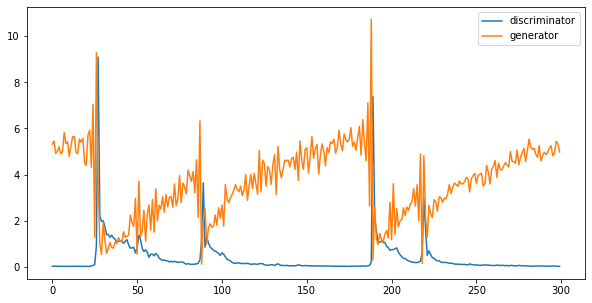

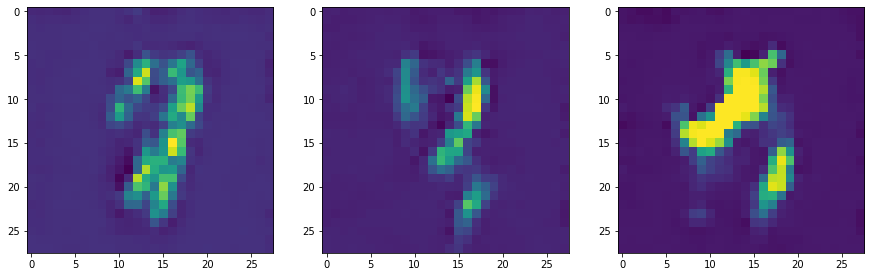

In [889]:
z = torch.randn((batch_size, 100, 1, 1)).to(device)
out = model.G(z)

img1 = out[0,0,:,:].detach().numpy()
img2 = out[1,0,:,:].detach().numpy()
img3 = out[2,0,:,:].detach().numpy()

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(range(len(disc_loss)), disc_loss, marker='', label="discriminator")
ax.plot(range(len(genr_loss)), genr_loss, marker='', label="generator")
ax.legend()

fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

# Problem 2

In [892]:
import torch
import torch.nn as nn
import nltk
from nltk.corpus import stopwords
import numpy as np
from tqdm import trange
from bs4 import BeautifulSoup
import re,string,unicodedata, copy
import random
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nltk.download('punkt')

#download corpus
nltk.download('gutenberg')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /home/jovyan/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [893]:
def denoise_text(text):
    #remove html strips
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    #remove \n
    text = re.sub('\n', ' ', text)
    #remove square brackets
    text = re.sub('\[[^]]*\]', '', text)
    #replace punctuation with space
    text = re.sub(r'[,.;@#?!&$\-]+\ *', ' ', text, flags=re.VERBOSE)
    #remove special characters
    text=re.sub(r'[^a-zA-z0-9\s]', '', text)
    #remove extra spaces
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = torch.optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = torch.optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

def train(model, iterator, optimizer, criterion, epoch):
    train_loss = 0
    correct = 0
    model.train()
    for batch_idx, (grams, targets) in enumerate(iterator):
        optimizer.zero_grad()
        output = model(grams).squeeze(1)
        loss = criterion(output.float(), targets.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(iterator)//4) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(iterator), train_loss/(batch_idx+1)))
    print(f"Epoch {epoch} complete!")
            
    return model

def text_to_index(text, d):
    corpus = torch.Tensor([d[word] for word in text])
    return corpus

def index_to_text(index, unique_words):
    return unique_words[index.int().numpy()]

In [983]:
# build model

class TextPredictioNet(nn.Module):
    def __init__(self, in_dim, h_dim, n_classes, n_layers, e_dim):
        super(TextPredictioNet, self).__init__()
        self.in_dim = in_dim
        self.h_dim = h_dim
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.e_dim = e_dim
        
        self.embedding = nn.Embedding(self.n_classes, 
                                      self.e_dim)
        
        self.lstm = nn.LSTM(input_size = self.e_dim, 
                                  hidden_size = self.h_dim, 
                                  num_layers = self.n_layers, 
                                  batch_first=True)
        
        self.preclassifier = nn.Linear(in_features=self.h_dim, 
                                    out_features=self.h_dim)
        
        self.classifier = nn.Linear(in_features=self.h_dim, 
                                    out_features=self.n_classes)

    def forward(self, x):
        x = x.int()
        
        # initialize H and C
        h0 = ((torch.rand((self.n_layers, len(x), self.h_dim)) - 0.5)*5).to(device)
        c0 = ((torch.rand((self.n_layers, len(x), self.h_dim)) - 0.5)*5).to(device)
        
        x_embed = self.embedding(x)
        m, _ = self.lstm(x_embed, (h0, c0))
        
        #prelogits = F.relu6(self.preclassifier(m[:, -1, :]))
        #prelogits = F.rrelu(self.preclassifier(m[:, -1, :]))
        #prelogits = F.tanhshrink(self.preclassifier(m[:, -1, :]))
        prelogits = F.tanh(self.preclassifier(m[:, -1, :]))
        logits = self.classifier(prelogits)
        return logits

In [895]:
# load dataset
corpus_raw = nltk.corpus.gutenberg.raw('austen-sense.txt')

# clean dataset
corpus_raw = denoise_text(corpus_raw)

# tokenize
corpus_t = nltk.word_tokenize(corpus_raw)

# convert to one-hot encoding
unique_words = np.unique(corpus_t)
d = {word: i for i, word in enumerate(unique_words)}
corpus = text_to_index(corpus_t, d)

# generate 6-grams
# split into 5-grams and targets
grams_pre = torch.stack(
    [corpus[i:i+6] for i in range(len(corpus)-6+1)], 
    dim=-1).permute(1,0)
grams = grams_pre[:,:5].float()
targets = grams_pre[:,5].float()

# pad dataset to N=100
#grams = torch.cat((grams,
#                     torch.zeros(len(grams), 95, len(unique_words)),
#                     dim=1)
# too big ???

In [984]:
# build data loader
gram_set = TensorDataset(grams, targets)
dl = DataLoader(gram_set, batch_size=256)

# instantiate model
in_dim = len(unique_words)
h_dim = 1000
n_classes = len(unique_words)
n_layers = 1
e_dim = 50

model = TextPredictioNet(in_dim, h_dim, n_classes, n_layers, e_dim)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = make_optimizer("Adam", model, lr=1, momentum=0, weight_decay=1)
scheduler = make_scheduler("MultiStepLR", optimizer, milestones=[5], factor=0.1)

# run training loop
for epoch in range(5):
    model = train(model, dl, optimizer, criterion, epoch+1)
print("Training complete!")

Train(1)[0%]: Loss: 8.7613
Train(1)[25%]: Loss: 731.3967
Train(1)[50%]: Loss: 903.5026
Train(1)[75%]: Loss: 1016.2027
Train(1)[100%]: Loss: 1118.1148
Epoch 1 complete!
Train(2)[0%]: Loss: 1399.5605
Train(2)[25%]: Loss: 1377.3873
Train(2)[50%]: Loss: 1357.0729
Train(2)[75%]: Loss: 1355.1985
Train(2)[100%]: Loss: 1385.1418
Epoch 2 complete!
Train(3)[0%]: Loss: 1548.7164
Train(3)[25%]: Loss: 1466.8875
Train(3)[50%]: Loss: 1440.1899
Train(3)[75%]: Loss: 1431.4260
Train(3)[100%]: Loss: 1456.8429
Epoch 3 complete!
Train(4)[0%]: Loss: 1597.2992
Train(4)[25%]: Loss: 1524.0725
Train(4)[50%]: Loss: 1494.8845
Train(4)[75%]: Loss: 1480.5818
Train(4)[100%]: Loss: 1500.6923
Epoch 4 complete!
Train(5)[0%]: Loss: 1735.0980
Train(5)[25%]: Loss: 1556.7397
Train(5)[50%]: Loss: 1522.8960
Train(5)[75%]: Loss: 1509.7466
Train(5)[100%]: Loss: 1530.8736
Epoch 5 complete!
Training complete!


In [986]:
# make predictions
text = ["his", "natural", "shyness", "was", "overcome"]
inds = text_to_index(text, d)

for i in range(95):
    inds_sub = inds[-5:-1].unsqueeze(0)
    pred = torch.argmax(model(inds_sub)).unsqueeze(0)
    inds = torch.cat((inds, pred), dim=0)

text_pred = " ".join(index_to_text(inds, unique_words))
print(text_pred)

his natural shyness was overcome a acting motive the themselves marriage they be ingratitude taken gained amiss nothing and could colonel quite brandon an of marianne both was of now women relations anybody agreed actions ask friend between great them verbal and perhaps and every birth instead feared his they for liked their a income idle it could was brother of little elinor of between elinor them of such education a knowledge thorough of offence more a than leave of to elinor for to once do give an her eager without great saying brother every his instead wife of and
